In [1]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.0'

# I/ Map

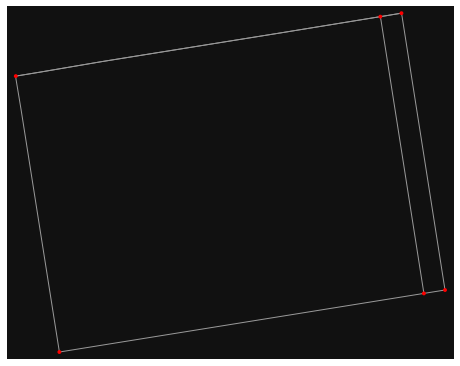

In [152]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 100m from point
G = ox.graph_from_point(location_point, dist=100, dist_type="bbox", network_type="drive")
fig, ax = ox.plot_graph(G, node_color="r")

In [156]:
def osmnx_to_regular_graph(osmnx_graph, is_oriented=False):
    """
        Convert osmnx graph to regular graph [(src, dest, length)]
        Params:
        Returns:
    """
    if not is_oriented:
        osmnx_graph = ox.utils_graph.get_undirected(osmnx_graph)
        
    osmnx_nodes = list(osmnx_graph.nodes)
    edges = []
    
    for src, dest, _ in list(osmnx_graph.edges):
        length = ox.utils_graph.get_route_edge_attributes(osmnx_graph,
            (src, dest), 'length')[0]
        edges.append((osmnx_nodes.index(src), osmnx_nodes.index(dest), length))
        
    return len(osmnx_nodes), edges

In [157]:
nodes, edges = osmnx_to_regular_graph(G)

In [158]:
for src, dest, length in edges:
    print(src, dest, length)

0 1 107.41299999999998
0 3 142.02499999999998
1 2 141.957
2 3 107.72500000000001
2 5 8.222999999999999
3 4 8.228
4 5 107.75699999999999


In [112]:
for u, v, keys, weight in G.edges(data="weight", keys=True):
    print(u, v, keys, weight)

65295314 65326736 0 None
65295314 6319217963 0 None
6319217961 65326736 0 None
6319217963 6319217969 0 None
6319217963 65295314 0 None
6319217963 6319217961 0 None
6319217969 6319217963 0 None
6319217970 6319217961 0 None
6319217970 6319217969 0 None


#### Sandbox

In [78]:
# Doc link: https://networkx.org/documentation/stable/reference/classes/generated/networkx.MultiDiGraph.edges.html#networkx.MultiDiGraph.edges
# Uncomment each cell one by one to understand

G = nx.MultiDiGraph()

nx.add_path(G, [0, 1, 2])
[e for e in G.edges()]

key = G.add_edge(2, 3, weight=5)
[e for e in G.edges()]

list(G.edges(data=True))  # default data is {} (empty dict)

list(G.edges(data="weight", default=1)) #default value for weight

list(G.edges(keys=True))  # default keys are integers

list(G.edges(data=True, keys=True))

list(G.edges(data="weight", default=1, keys=True))

list(G.edges([0, 2]))

list(G.edges(0))

[(0, 1)]

In [79]:
assert G.number_of_nodes() == len(G.nodes)

In [80]:
assert G.number_of_edges() == len(G.edges)

# II/ Graph traversal

# III/ Benchmark

# ?/ Analysis

See `Part 5: calculate basic network indicators` of notebook `01-overview-osmnx` for further detail on analysis.

In [6]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats

{'n': 205,
 'm': 467,
 'k_avg': 4.556097560975609,
 'edge_length_total': 45933.512000000046,
 'edge_length_avg': 98.35869807280524,
 'streets_per_node_avg': 3.6634146341463416,
 'streets_per_node_counts': {0: 0, 1: 9, 2: 3, 3: 40, 4: 149, 5: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.04390243902439024,
  2: 0.014634146341463415,
  3: 0.1951219512195122,
  4: 0.7268292682926829,
  5: 0.01951219512195122},
 'intersection_count': 196,
 'street_length_total': 35515.20500000001,
 'street_segment_count': 350,
 'street_length_avg': 101.47201428571431,
 'circuity_avg': 1.002100451240503,
 'self_loop_proportion': 0.0}